In [1]:
!pip install fredapi > /dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas.tseries.offsets import MonthEnd
from fredapi import Fred
fred_key='e5a9aa45ccc6a9d379d7531e373f67bb'
fred = Fred(api_key=fred_key)

The system cannot find the path specified.


### Import and clean FX data

In [2]:
# Get BIS data
    # Go to: https://data.bis.org/bulkdownload
    # Download: Bilateral exchange rates (CVS, flat) & Consumer prices index (CVS, flat)
    # Save in same folder as code

In [3]:
fx = pd.read_csv(r'WS_XRU_csv_FLAT.csv')

In [4]:
fx = fx[fx['FREQ:Frequency'].str.startswith('M')]
fx = fx[fx['COLLECTION:Collection'].str.startswith('E')]

In [5]:
countries = ['US', 'XM', 'JP', 'GB', 'CN', 'AU', 'CA', 'CH',
             'HK', 'SG', 'SE', 'KR', 'NO', 'NZ', 'IN', 'MX',
             'ZA', 'BR', 'DK', 'PL', 'TH', 'IL', 'ID', 'CZ',
             'AE', 'TR', 'HU', 'CL', 'SA', 'PH', 'MY', 'CO',
             'RU', 'RO', 'PE', 'DE', 'FR', 'IT', 'ES']
fx = fx[fx['REF_AREA:Reference area'].str[:2].isin(countries)]

In [6]:
columns_to_keep = ['REF_AREA:Reference area', 'CURRENCY:Currency', 
                   'TIME_PERIOD:Time period or range', 'OBS_VALUE:Observation Value']
fx = fx[columns_to_keep]
fx = fx.reset_index(drop=True)
fx = fx.rename(columns={
    'REF_AREA:Reference area': 'country',
    'CURRENCY:Currency': 'currency',
    'TIME_PERIOD:Time period or range': 'date',
    'OBS_VALUE:Observation Value': 'fx'})

In [7]:
fx['date'] = pd.to_datetime(fx['date'])
fx.set_index('date', inplace=True)
fx['currency'] = fx['currency'].str[:3]

In [8]:
fx.loc[fx['country'] == 'DE: Germany', 'currency'] = 'DEM'
fx.loc[fx['country'] == 'FR: France', 'currency'] = 'FRF'
fx.loc[fx['country'] == 'IT: Italy', 'currency'] = 'ITL'
fx.loc[fx['country'] == 'ES: Spain', 'currency'] = 'ESP'

### Import and clean CPI data

In [9]:
cpi = pd.read_csv(r'WS_LONG_CPI_csv_flat.csv')

In [10]:
cpi = cpi[cpi['FREQ:Frequency'].str.startswith('M')]
cpi = cpi[cpi['UNIT_MEASURE:Unit of measure'].str.startswith('628')]

In [11]:
countries = ['US', 'XM', 'JP', 'GB', 'CN', 'AU', 'CA', 'CH',
             'HK', 'SG', 'SE', 'KR', 'NO', 'NZ', 'IN', 'MX',
             'ZA', 'BR', 'DK', 'PL', 'TH', 'IL', 'ID', 'CZ',
             'AE', 'TR', 'HU', 'CL', 'SA', 'PH', 'MY', 'CO',
             'RU', 'RO', 'PE', 'DE', 'FR', 'IT', 'ES']
cpi = cpi[cpi['REF_AREA:Reference area'].str[:2].isin(countries)]

In [12]:
columns_to_keep = ['REF_AREA:Reference area','TIME_PERIOD:Time period or range',
                   'OBS_VALUE:Observation Value']
cpi = cpi[columns_to_keep]
cpi = cpi.reset_index(drop=True)
cpi = cpi.rename(columns={
    'REF_AREA:Reference area': 'country',
    'TIME_PERIOD:Time period or range': 'date',
    'OBS_VALUE:Observation Value': 'cpi'})

In [13]:
cpi['date'] = pd.to_datetime(cpi['date'])
cpi.set_index('date', inplace=True)

In [14]:
country_currency_map = fx[['country', 'currency']].drop_duplicates().set_index('country')['currency'].to_dict()
cpi['currency'] = cpi['country'].map(country_currency_map)

### Pivot data

In [15]:
fx = fx.pivot_table(index='date', columns='currency', values='fx')
cpi = cpi.pivot_table(index='date', columns='currency', values='cpi')

In [16]:
# From 1980 onwards
fx = fx[fx.index.year >= 1980]
cpi = cpi[cpi.index.year >= 1980]

In [17]:
# Change to last day of each month
fx.index = fx.index + pd.offsets.MonthEnd(0)
cpi.index = cpi.index + pd.offsets.MonthEnd(0)

In [18]:
# Append EU CPI
eu_cpi = fred.get_series('CP0000EZ19M086NEST')
eu_cpi = eu_cpi.to_frame(name='EUR')
eu_cpi.index = pd.to_datetime(eu_cpi.index) + pd.offsets.MonthEnd(0)
base = eu_cpi.loc[pd.to_datetime('2009-12-31')]
eu_cpi = (eu_cpi / base) * 100
cpi['EUR'].fillna(eu_cpi['EUR'],inplace=True)

In [19]:
# Copy latest CPI values in one additional month
last_date = cpi.index[-1]
next_month_last_day = (last_date + MonthEnd(1)).strftime('%Y-%m-%d')
last_row_cpi = cpi.iloc[-1]
new_row = pd.Series(last_row_cpi.values, index=last_row_cpi.index, name=next_month_last_day)
cpi = cpi.append(new_row)
cpi.index = pd.to_datetime(cpi.index)

C:\Users\educh\AppData\Local\Temp\ipykernel_47776\2361257056.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cpi = cpi.append(new_row)


In [20]:
# Save cleaned FX and CPI data in excel
import os
fx.to_excel(os.path.join(os.getcwd(), 'fx.xlsx'))
cpi.to_excel(os.path.join(os.getcwd(), 'cpi.xlsx'))

### PPP (in-sample)

In [21]:
# CPI ratio vs the US
cpi_ratio = cpi.div(cpi['USD'], axis=0)

In [22]:
rer = fx / cpi_ratio
avg_rer = rer.mean(axis=0)

In [23]:
ppp = avg_rer * cpi_ratio
dev = (ppp / fx - 1)*100

### PPP (out-of-sample)

In [24]:
exp_avg_rer = rer.expanding().mean()
ppp_oos = exp_avg_rer * cpi_ratio
dev_oos = (ppp_oos / fx - 1)*100

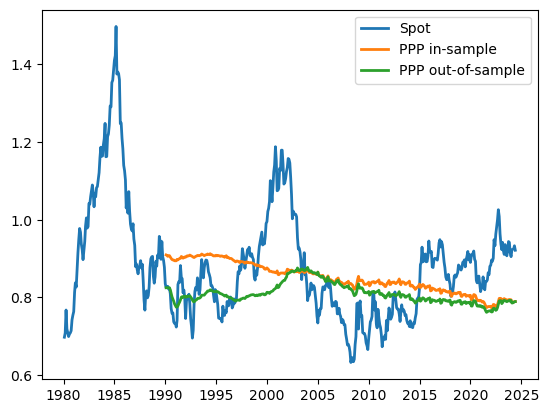

In [25]:
# Plot Spot vs PPP
x = 'EUR'

plt.figure()
plt.plot(fx[x], label='Spot', lw=2)
plt.plot(ppp[x], label='PPP in-sample', lw=2)
plt.plot(ppp_oos[x], label='PPP out-of-sample', lw=2)

plt.legend()
plt.show()

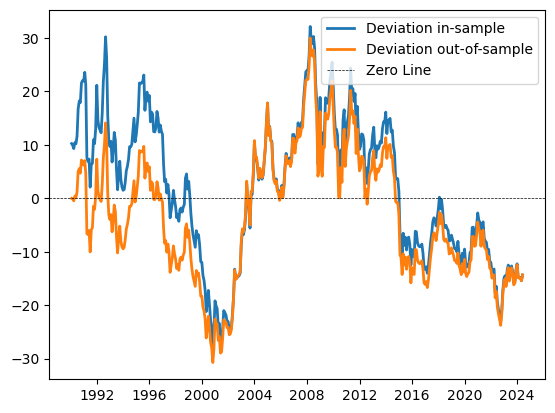

In [26]:
# Plot Deviations from PPP fair value
x = 'EUR'

plt.figure()
plt.plot(dev[x], label='Deviation in-sample', lw=2)
plt.plot(dev_oos[x], label='Deviation out-of-sample', lw=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, label='Zero Line')

plt.legend()
plt.show()

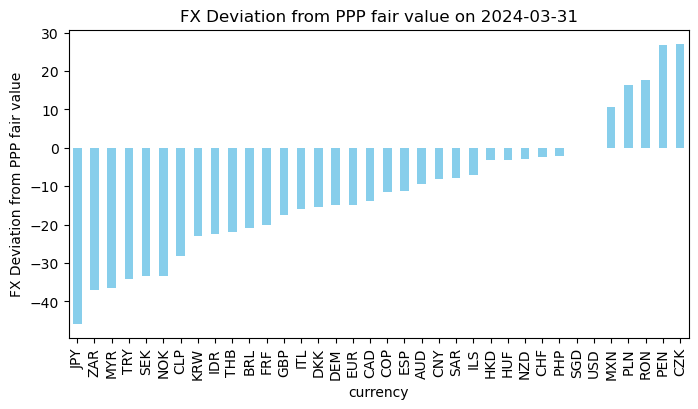

In [27]:
# Compare deviations of spot from PPP implied fair value
specific_date = '2024-03-31'
selected_data = dev_oos.loc[specific_date, :].dropna()
ordered_data = selected_data.sort_values()
ax = ordered_data.plot(kind='bar', color='skyblue', figsize=(8, 4))
ax.set_ylabel('FX Deviation from PPP fair value')
ax.set_title(f'FX Deviation from PPP fair value on {specific_date}')
plt.show()

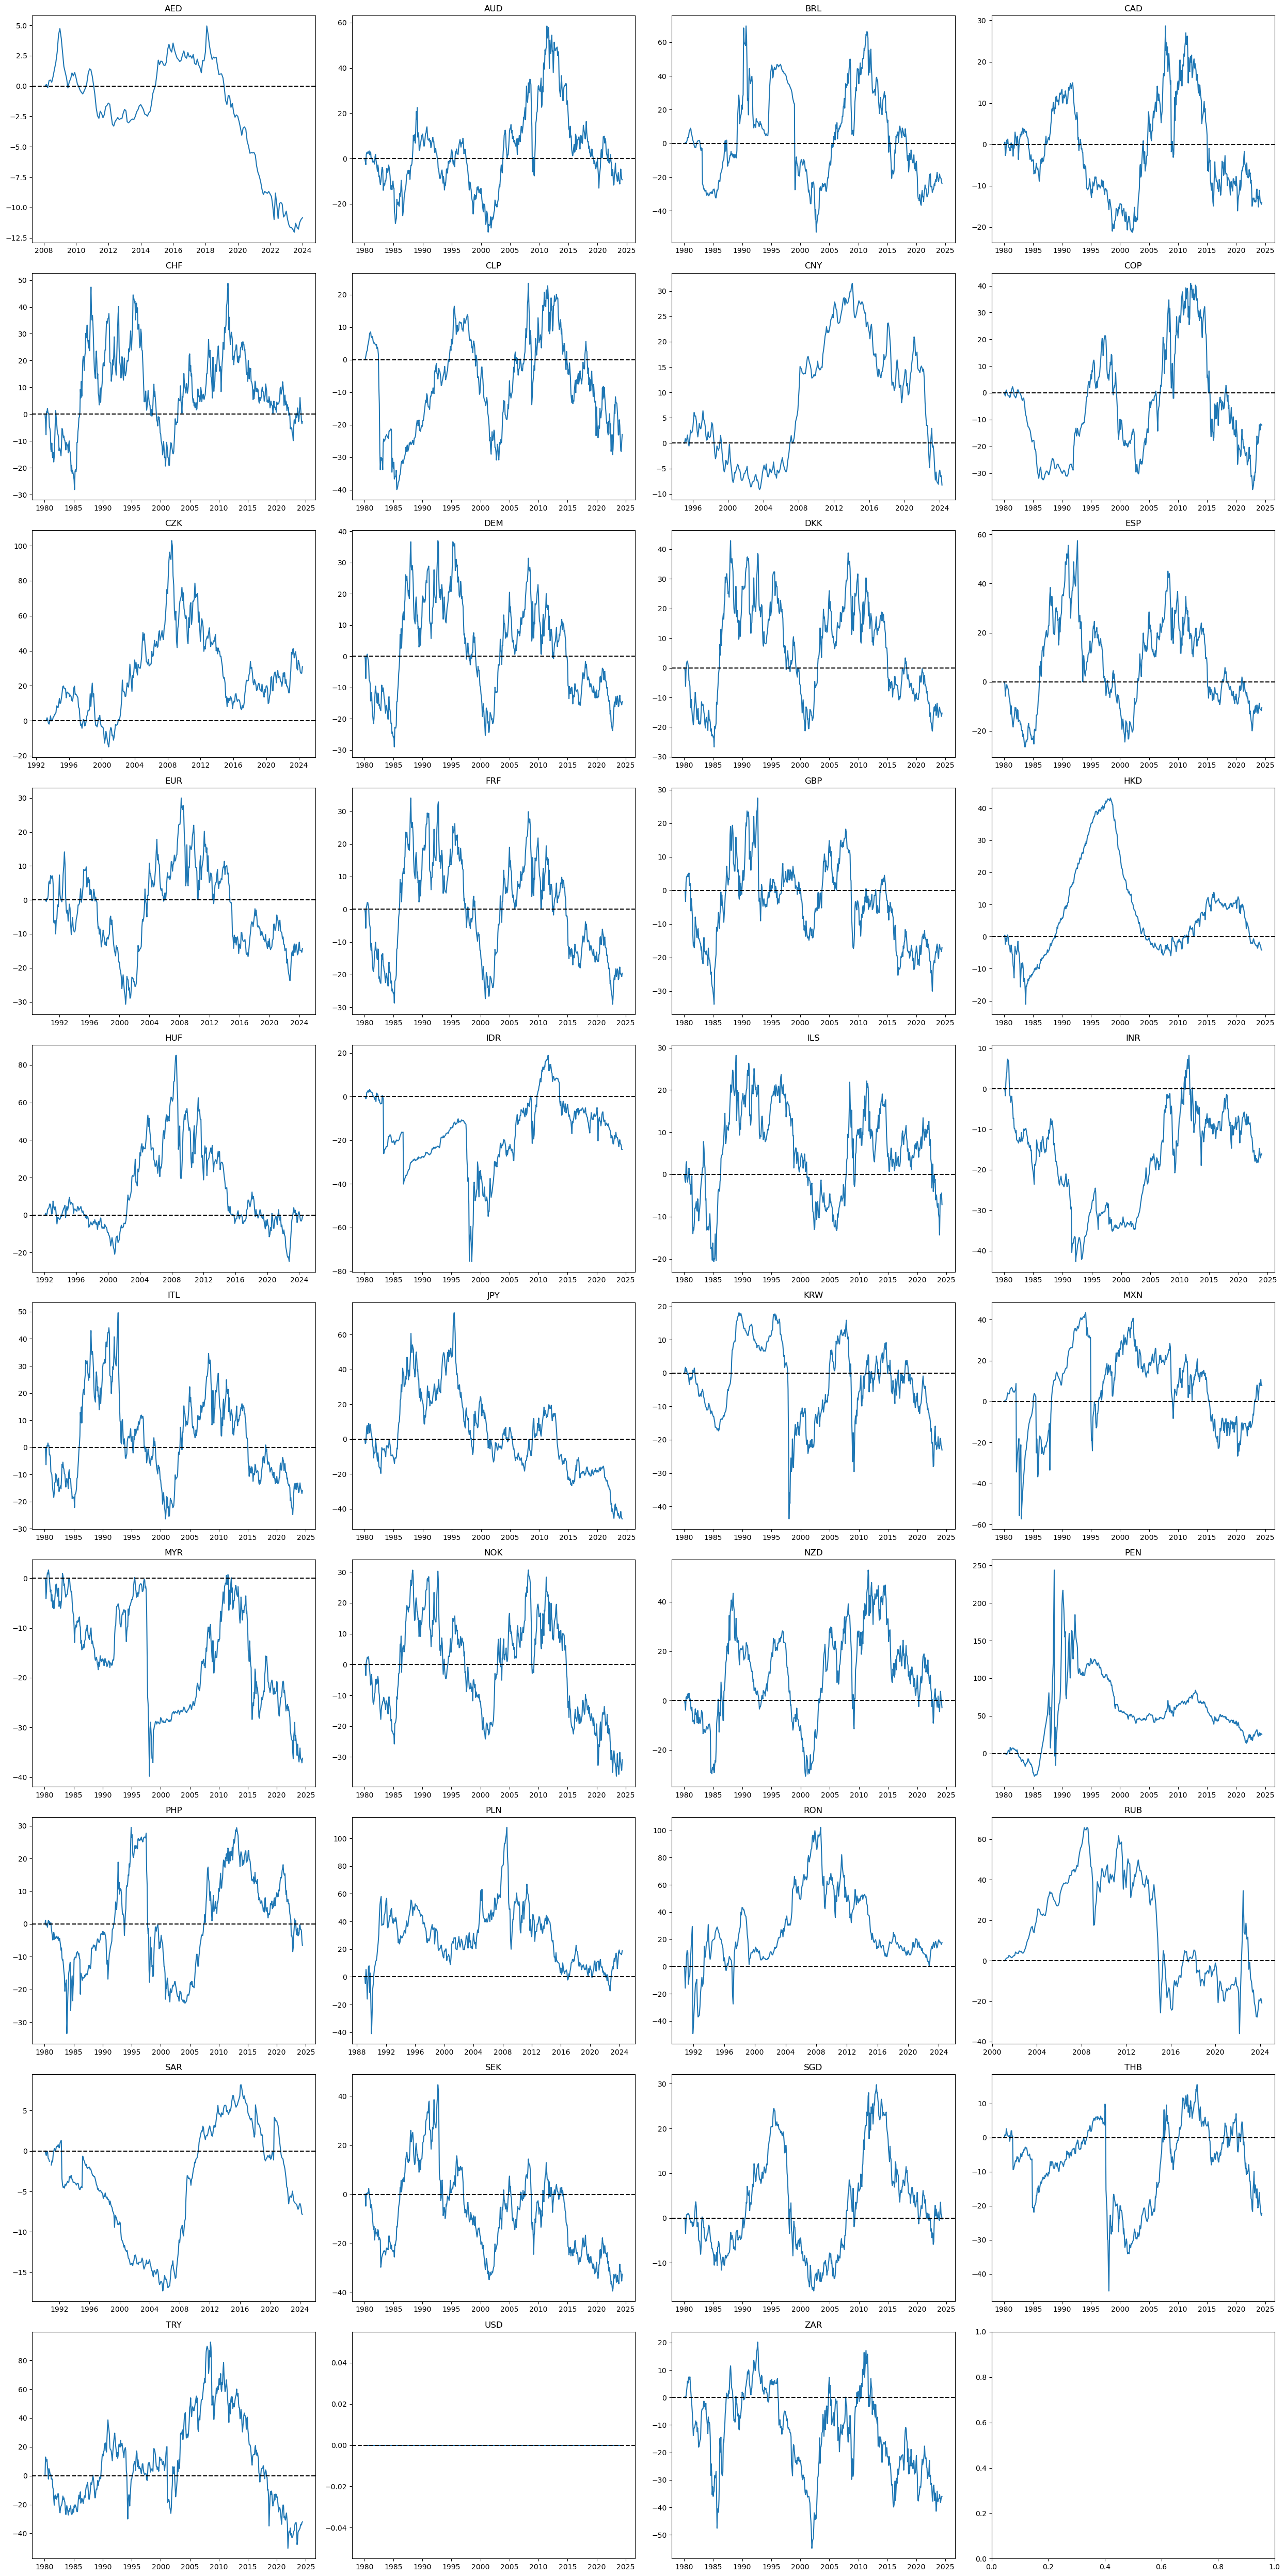

In [28]:
# Get the list of currencies
currencies = dev_oos.columns

# Determine the number of rows and columns for subplots
num_currencies = len(currencies)
num_cols = 4  # Adjust the number of columns as desired
num_rows = int(np.ceil(num_currencies / num_cols))

# Create subplots with the determined number of rows and columns
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 5*num_rows))

# Iterate over currencies and plot
for i, currency in enumerate(currencies):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.plot(dev_oos.index, dev_oos[currency])
    ax.axhline(y=0, color='black', linestyle='--')  # Add horizontal line at y=0
    ax.set_title(currency)

# Adjust layout
plt.tight_layout()
plt.show()

In [29]:
# Save out-of-sample results in excel
with pd.ExcelWriter('ppp.xlsx') as writer:
    ppp_oos.to_excel(writer, sheet_name='ppp_oos')
    dev_oos.to_excel(writer, sheet_name='dev_oos')